# Speech Processing Basics

- Speech processing basics: Recording, reading, resampling, writing, playing, trimming, plotting, etc.

- Windowing of speech

- Analyzing voiced speech frame (magnitude spectrum)

- (Short time) Fourier Transform (Spectrogram visualization)

In [3]:
# Import all the required packages

import scipy.io.wavfile as wav
import scipy.signal as sig
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
from scipy.io import wavfile

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Speech processing basics

In [4]:
fs = 44100  # Sample rate/sampling frequency
seconds = 4  # Duration of recording

### recording

In [5]:
# Record 3 seconds of your speech (i.e,, Hello. This is a sound example by XX)
data = sd.rec(int(seconds * fs), samplerate=fs, channels=1)
sd.wait()  # Wait until recording is finished

### reading

In [6]:
# Play the recording
sd.play(data, fs)
sd.wait()  # Wait until file is done playing

if theres no sound, check the audio io setting on the laptop and restart the notebook

### writing

In [12]:
# filename = 'Hello.wav'
# # write to storage
# wavfile.write(filename, fs, data)

### playing

In [14]:
# remove data, such that we can read it again
del data
filename = 'hello.wav'

# read from storage
fs, data = wavfile.read(filename)

# Play to check that we recovered it
sd.play(data, fs)
sd.wait()

### resampling

In [53]:
# Read the audio file and sampling rate
Fs_target = 16000
Fs,data = wav.read('hello.wav')
data = data[:, 0]

# Transform signal from int16 (-32768 to 32767) to float32 (-1,1)
if type(data[0]) == np.int16:
    data = np.divide(data,32768,dtype=np.float32)

# Make sure the sampling rate is 16kHz
if not (Fs == Fs_target):
    data = sig.resample_poly(data, Fs_target,Fs)
    Fs = Fs_target

### ploting

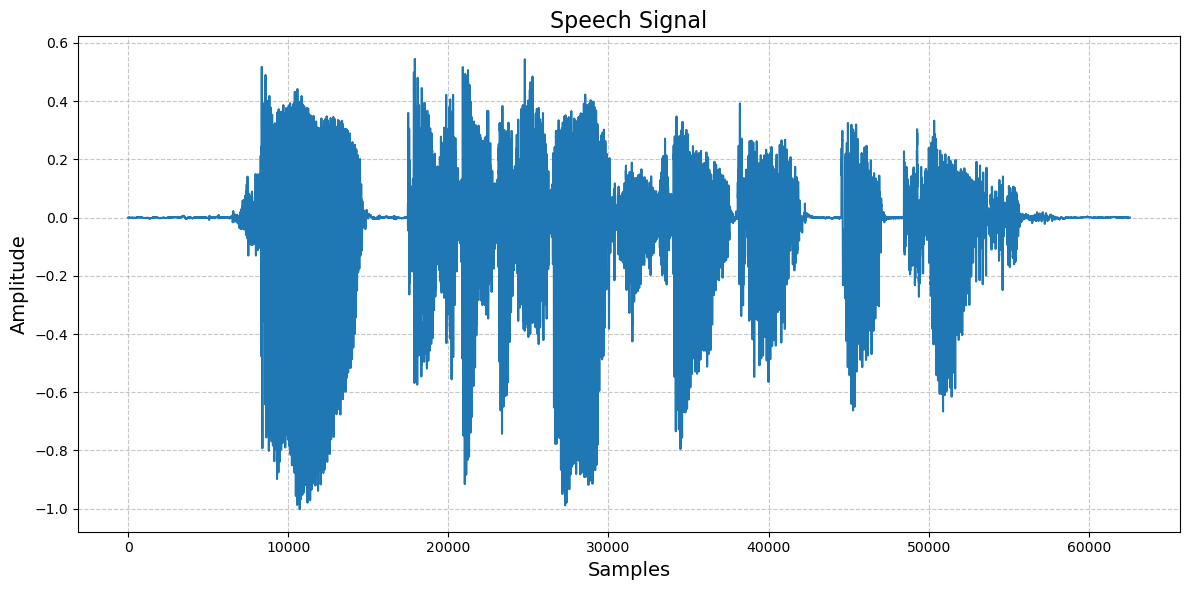

In [54]:
plt.figure(figsize=(12, 6))

# Plot the data with a softer color
plt.plot(data)

# Add title and labels
plt.title('Speech Signal', fontsize=16)
plt.xlabel('Samples', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### trimming
trim the unwanted clicking sound at the beginning

In [55]:
# choose the start_index and end_index manually to trim your soundfile
start_index = 5000
end_index = 58000
data1 = data[start_index:end_index]

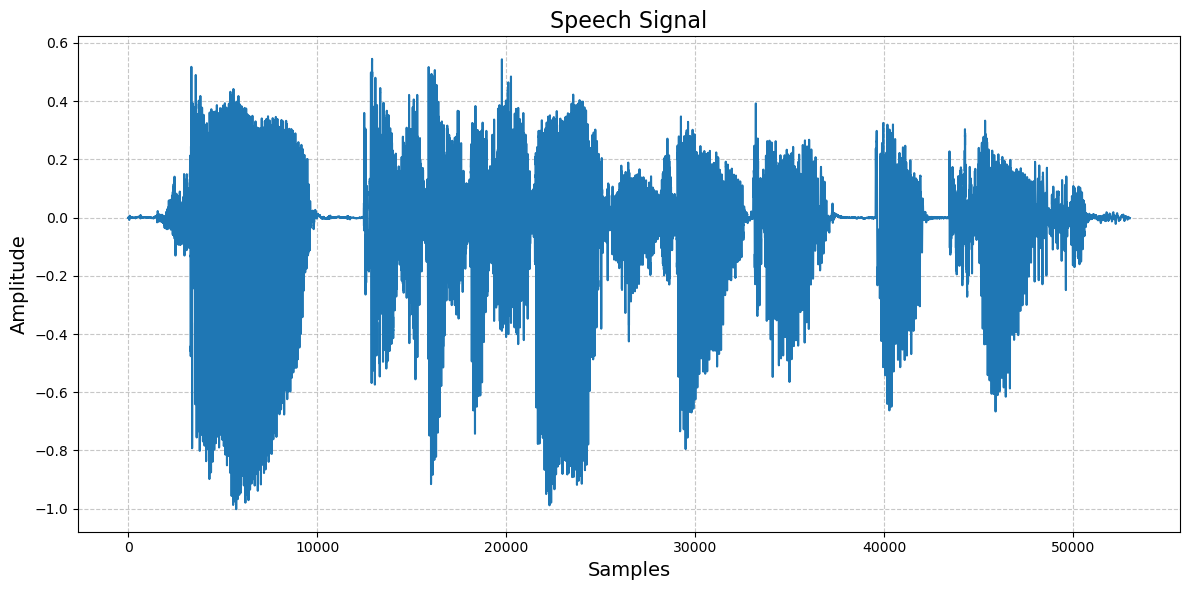

In [56]:
plt.figure(figsize=(12, 6))

# Plot the data with a softer color
plt.plot(data1)

# Add title and labels
plt.title('Speech Signal', fontsize=16)
plt.xlabel('Samples', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [31]:
# sd.play(data1, Fs)
# sd.wait()

In [26]:
# wavfile.write(filename, Fs, data1)

## Windowing of speech

define a windowing function:
- input: data, window/frame length(in samples), hop size(in samples), window type
- output: output matrix of dimension $n\times m$ ($n$: frame length,  $m$: number of frames)

We will use a frame length of 25ms, with 50\% overlap. The basic window types should be rectangular, Hann, Hamming, Cosine (square root of Hann) window types.

\begin{equation}
\text{number of frames} = 1 + floor \{\frac{(n-k)}{o}\},
\end{equation}

where $n=\text{data length}$ in samples, $k=\text{frame length}$ in samples, and $o=\text{overlap}$ in samples.

Note, if the end sample of the frame segment is larger than the data length, zero-pad the data (with the remainder) to achieve constant frame length.

In [57]:
def windowing(data, frame_length, hop_size, windowing_function):
    data = np.array(data)
    number_of_frames = 1 + int(np.floor((len(data)-frame_length)/hop_size))
    frame_matrix = np.zeros((frame_length,number_of_frames))

    if windowing_function == 'rect':
        window = np.ones((frame_length))
    elif windowing_function == 'hann':
        window = np.hanning(frame_length)
    elif windowing_function == 'cosine':
        window = np.sqrt(np.hanning(frame_length))
    elif windowing_function == 'hamming':
        window = np.hamming(frame_length)
    else:
        os.error('Windowing function not supported')
        
    
    for i in range(number_of_frames):
        frame = np.zeros(frame_length) # Initialize frame as zeroes (zero padding)
        start = i*hop_size
        stop = np.minimum(start+frame_length,len(data))
        frame[0:stop-start] = data[start:stop]
        frame_matrix[:,i] = np.multiply(window,frame)   
    return frame_matrix

In [58]:
# Split the data sequence into windows.
frame_length_ms = 25 # in miliseconds
hop_length_ms = 12.5 # in miliseconds

frame_length = int(np.around((frame_length_ms/1000)*Fs))# 25ms in samples
hop_size = int(np.around((hop_length_ms/1000)*Fs))# 12.5 ms (25/2 ms) in samples (50% overlap)window_types = ('rect','hann','cosine','hamming')

In [59]:
frame_matrix = windowing(data, frame_length, hop_size, 'hamming')# Windowing

In [60]:
frame_matrix.shape

(400, 311)

Frame length in samples = 400

Number of frames = 311

## Analyzing voiced speech frame

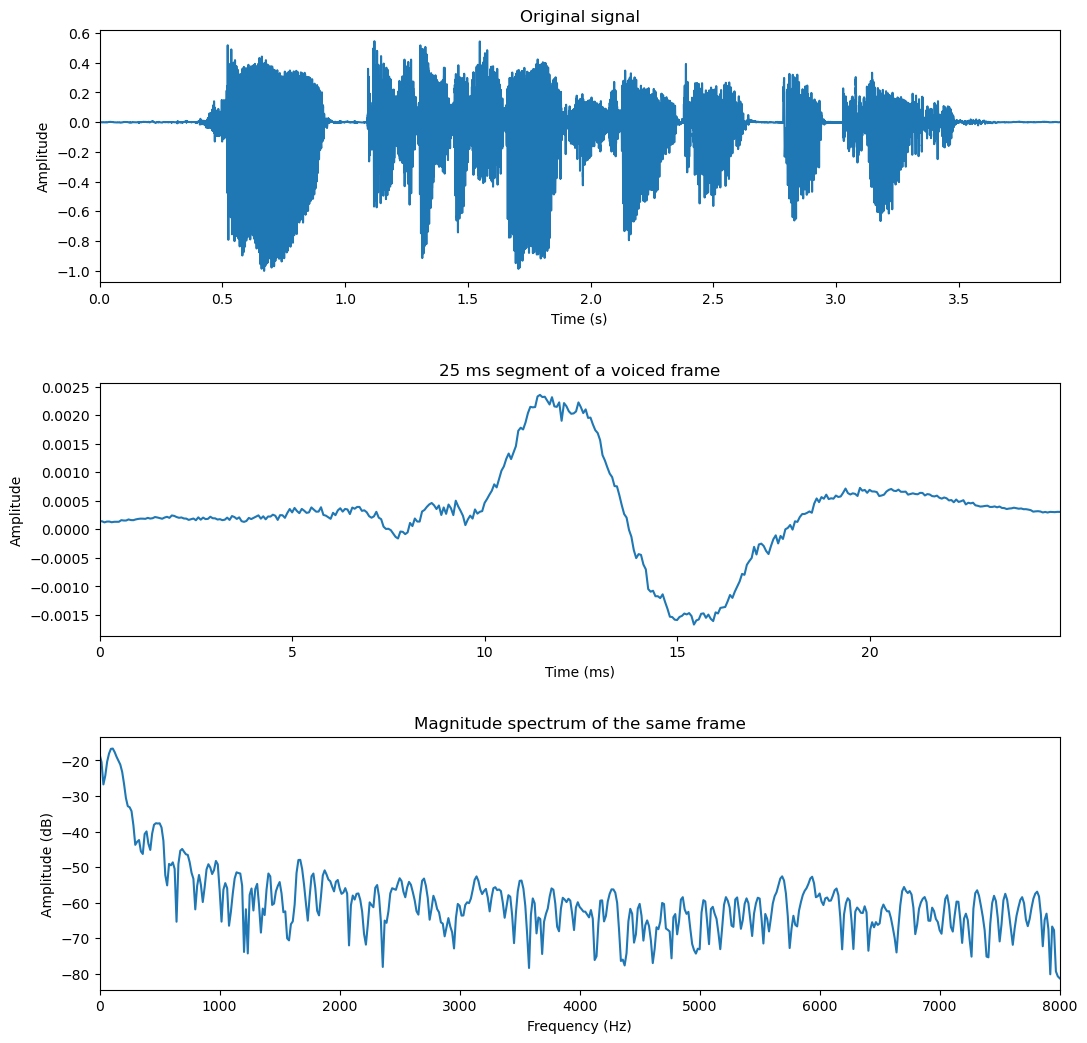

In [61]:
# Figure 1: Create a new figure with three subplots.
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12))
fig.tight_layout()


plt.figure(1)
## Plot the whole signal into subplot 1. Denote x-axis as time in seconds and y-axis as Amplitude.
### Set appropriate strings to title, xlabel and ylabel
plt.subplot(3,1,1)
t_axis1 = np.divide(range(len(data)),Fs)
plt.plot(t_axis1,data)
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('Original signal')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')

    
## Plot a VOICED frame from frame_matrix into subplot 2. Denote x-axis as milliseconds and y-axis as Amplitude.
### Set appropriate strings to title, xlabel and ylabel
voiced_frame_index = 15 #set it manually based on your speech data
plt.subplot(3,1,2)
t_axis2 = np.divide(range(frame_length),Fs/1000)
plt.plot(t_axis2,frame_matrix[:,voiced_frame_index])
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('25 ms segment of a voiced frame')
plt.ylabel('Amplitude')
plt.xlabel('Time (ms)')
    

## Plot the magnitude spectrum of the above frame into
## subplot 3. Denote x-axis as Hz, and y-axis as decibels.
### Set appropriate strings to title, xlabel and ylabel
plt.subplot(3,1,3)
Nfft = 1024
frame_fft = np.fft.rfft(frame_matrix[:,voiced_frame_index],n=Nfft)
f_axis = np.divide(range(len(frame_fft)),((len(frame_fft)-1)/(Fs/2)))
plt.plot(f_axis,20*np.log10(np.absolute(frame_fft)))
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('Magnitude spectrum of the same frame')
plt.ylabel('Amplitude (dB)')
plt.xlabel('Frequency (Hz)')


plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show(block=False)

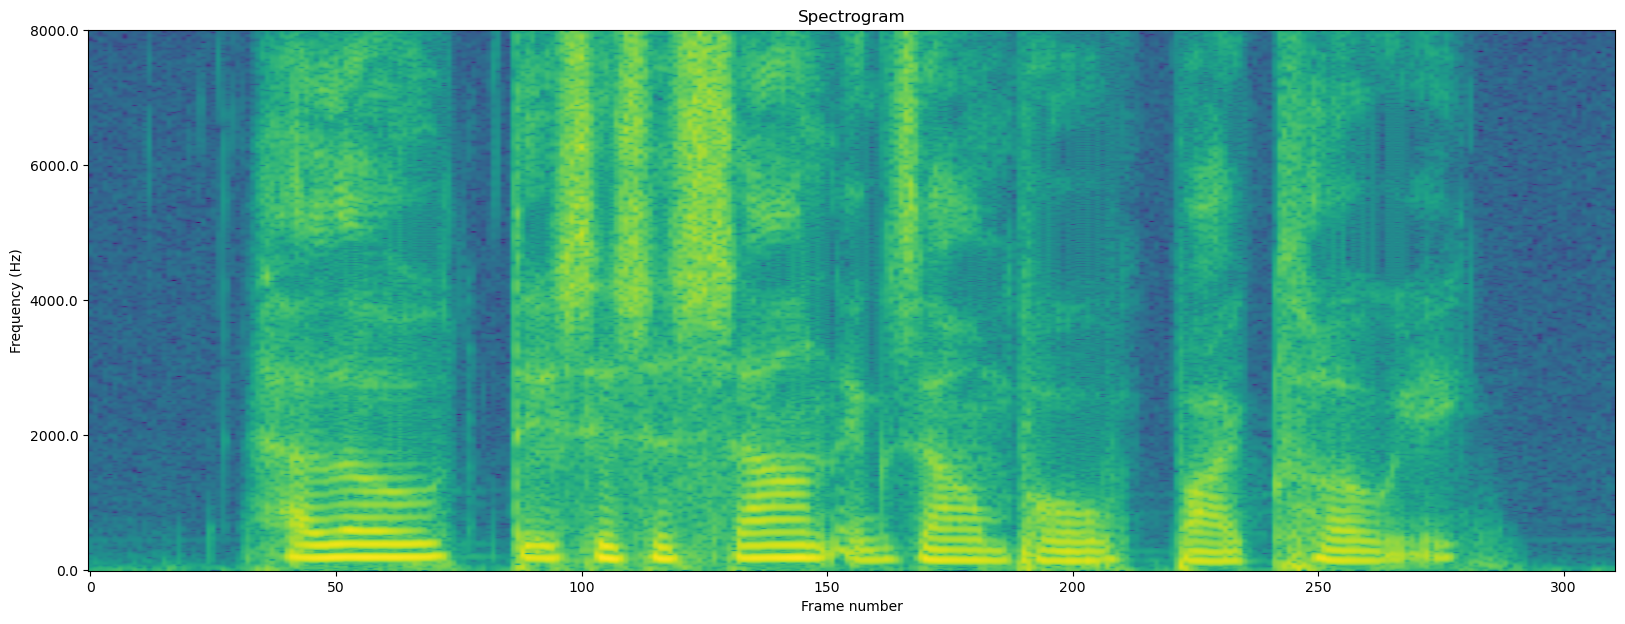

In [62]:
## Figure 2: Compute and plot the spectrogram of the whole signal into a new figure.
## Denote x-axis as frame number and y-axis as Frequency in Hz
## Set appropriate strings to title, xlabel and ylabel

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))
fig.tight_layout()

plt.figure(1)
frame_matrix_fft = np.fft.rfft(frame_matrix, axis=0, n=Nfft)
frame_matrix_fft = 20 * np.log10(np.absolute(np.flipud(frame_matrix_fft)))
plt.imshow(frame_matrix_fft, aspect='auto')
ytickpos = np.flipud(np.linspace(0,Nfft/2,5)).astype(int)
plt.yticks(np.linspace(0, Nfft/2,5), f_axis[ytickpos])
plt.title('Spectrogram')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Frame number')
plt.show()

Changing the frame_length_ms impacts the shape of the frame matrix and the time-frequency resolution of the plots. Increasing the frame length leads to fewer, longer frames, resulting in fewer columns in the frame matrix and higher frequency resolution but lower time resolution in the spectrogram. Conversely, decreasing the frame length increases the number of frames, providing higher time resolution but lower frequency resolution. The frame matrix changes similarly when adjusting hop_length_ms, where increasing hop length reduces the number of frames and lowers time resolution, while decreasing it does the opposite.

Adjusting the number of FFT points, n, affects the frequency resolution of the magnitude spectrum and spectrogram. Higher n values lead to finer frequency resolution, while lower n values increase time resolution at the expense of frequency detail. Recording a sound sample at a higher sampling rate (Fs = 32000 Hz) doubles the frequency range (extending up to 16000 Hz) and enhances the frequency resolution, but the time axis remains similar, and the upper half of the spectrogram may show near-zero values due to the Nyquist limit.